In [1]:
import gin
gin.add_config_file_search_path('./configs')
import torch
import os
import numpy as np
from loaders import get_dataloaders
import argparse

from model import RectifiedFlow
import matplotlib.pyplot as plt

/data/nils/miniconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/data/nils/miniconda3/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-02-18 10:12:34.469089: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
gin.parse_config_file("base.gin")
device = "cuda:1"
checkpoint_path = "/data/nils/repos/NIMAT_PROJECT/runs/VAMOU2/checkpoint_260000.pt"


model = RectifiedFlow(device = device)
state_dict = torch.load(checkpoint_path, map_location ="cpu")
model.net.load_state_dict(state_dict["model_state"])


ERROR:root:Path not found: base.gin
/tmp/ipykernel_795163/291501187.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location

<All keys matched successfully>

In [14]:
faces_ds, faces_loader, hubble_ds, hubble_loader = get_dataloaders(batch_size = 8, num_workers = 0)

In [26]:
x1.shape

torch.Size([8, 3, 128, 128])

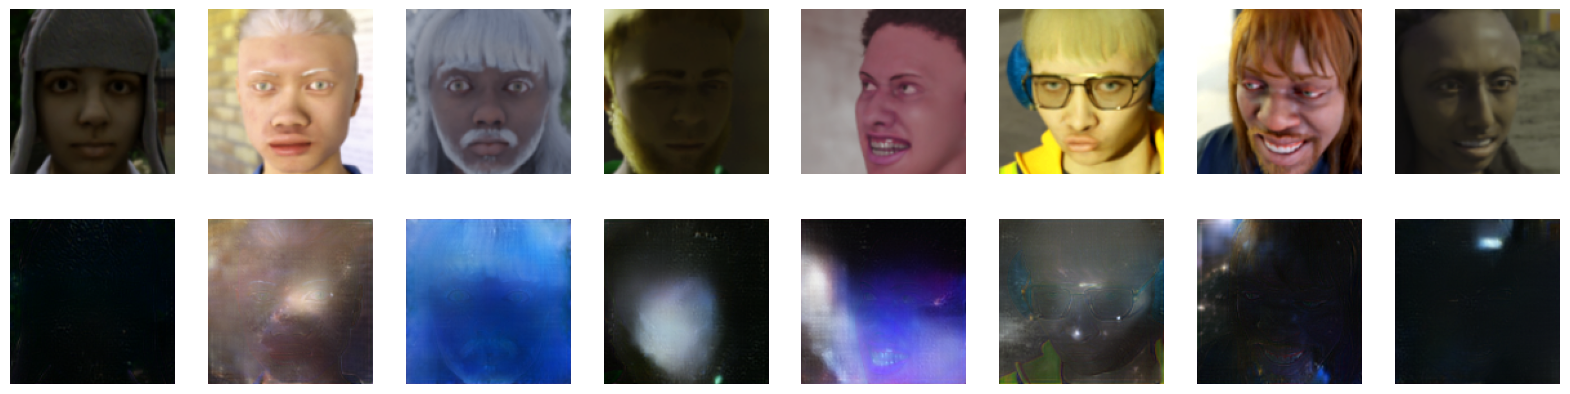

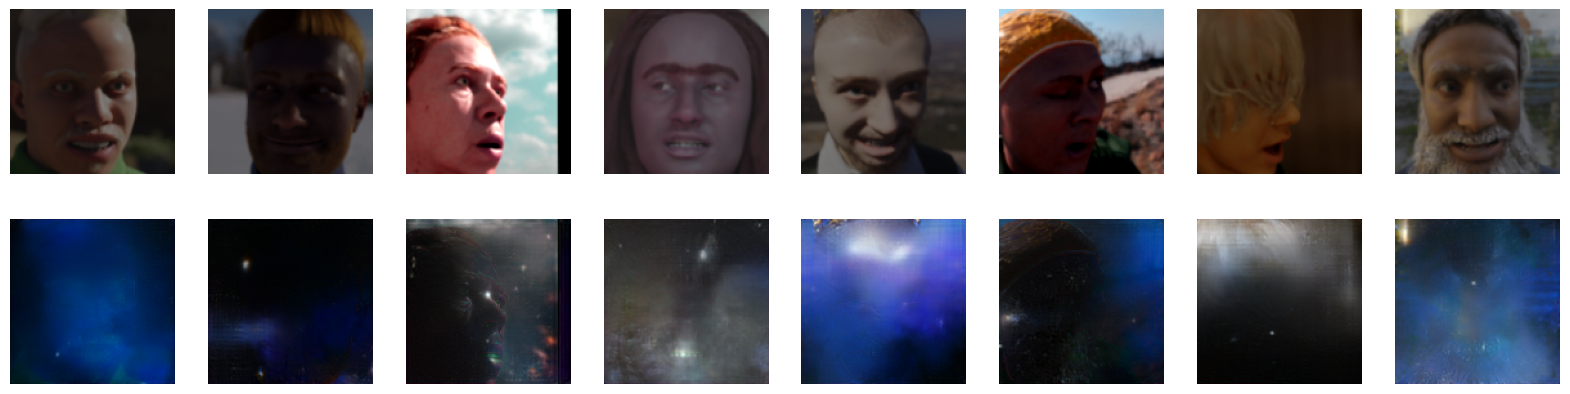

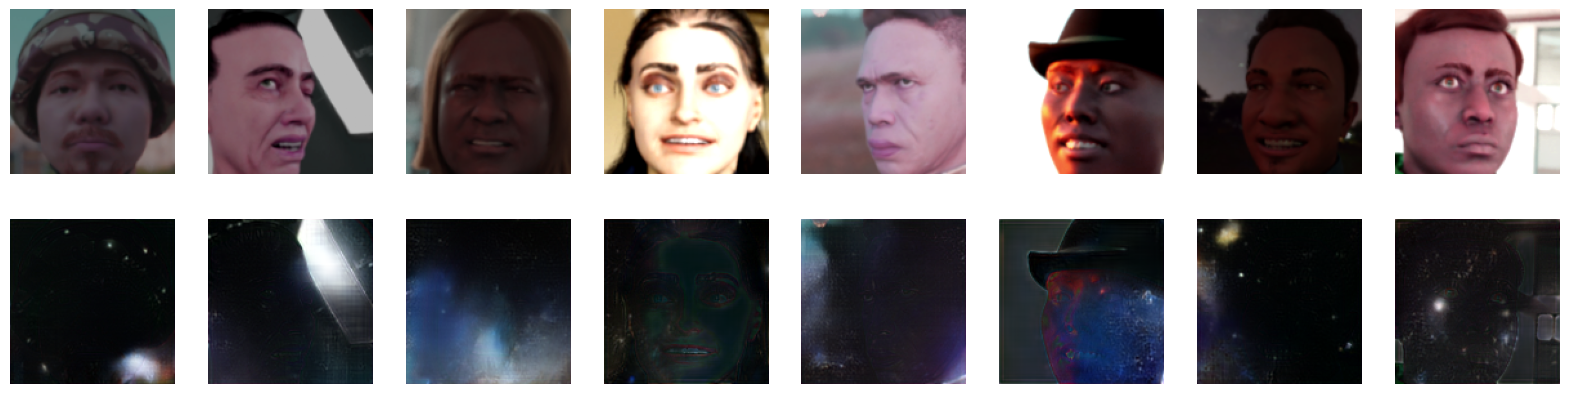

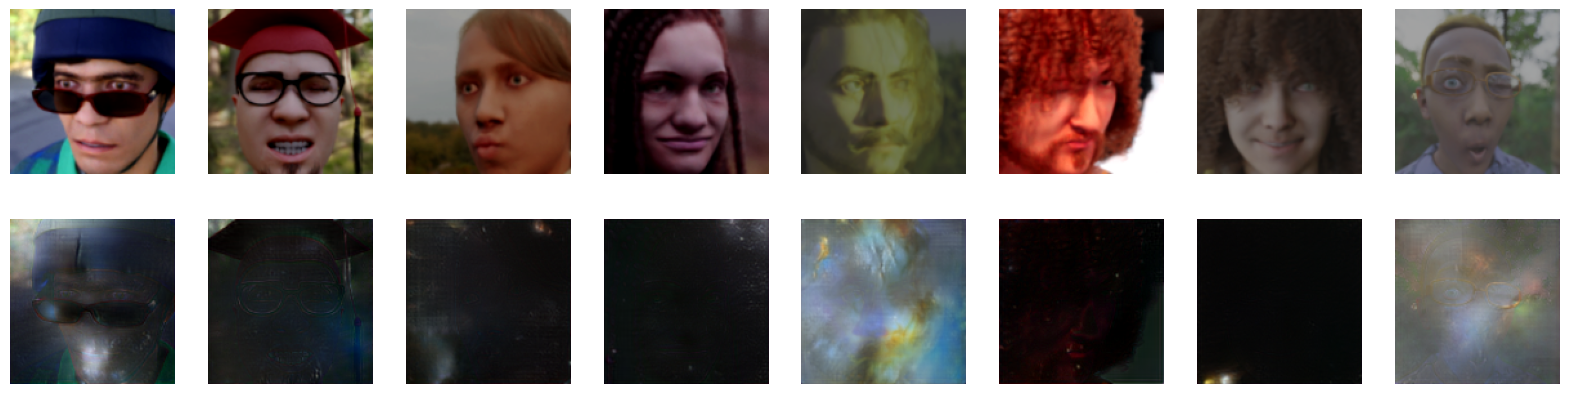

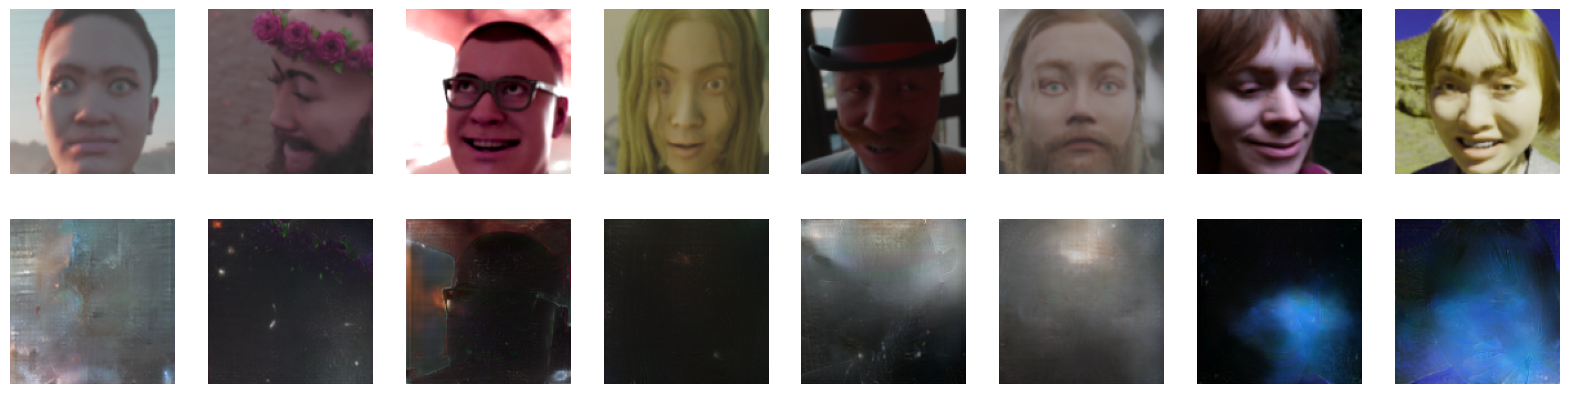

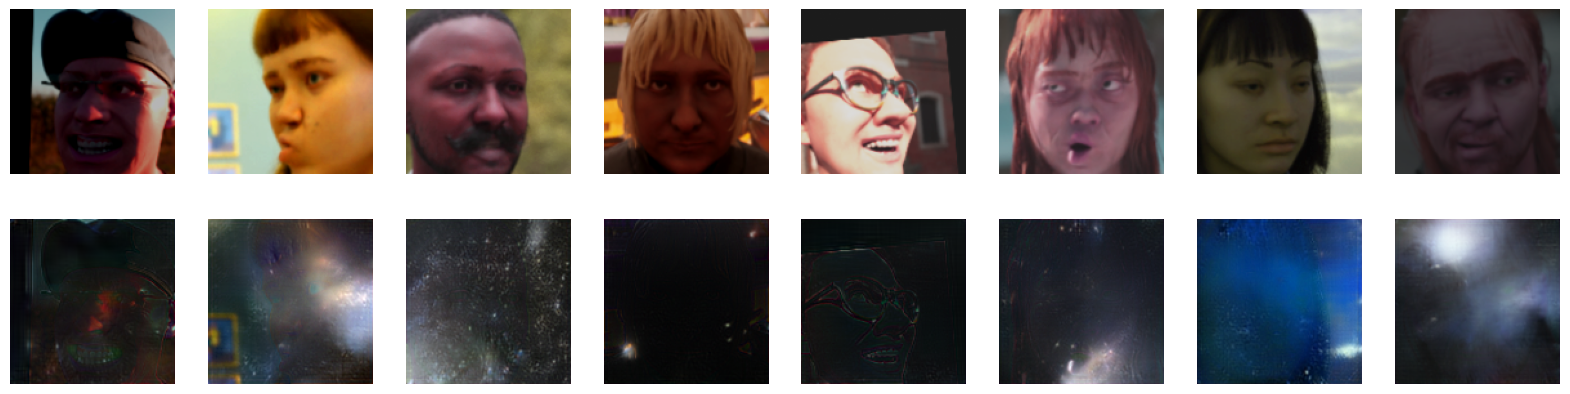

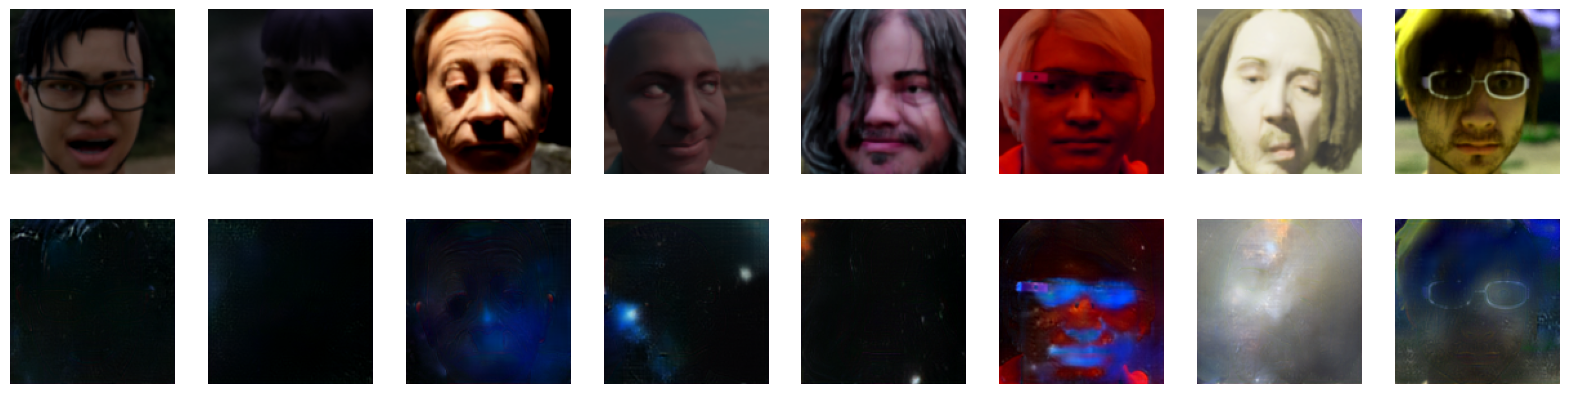

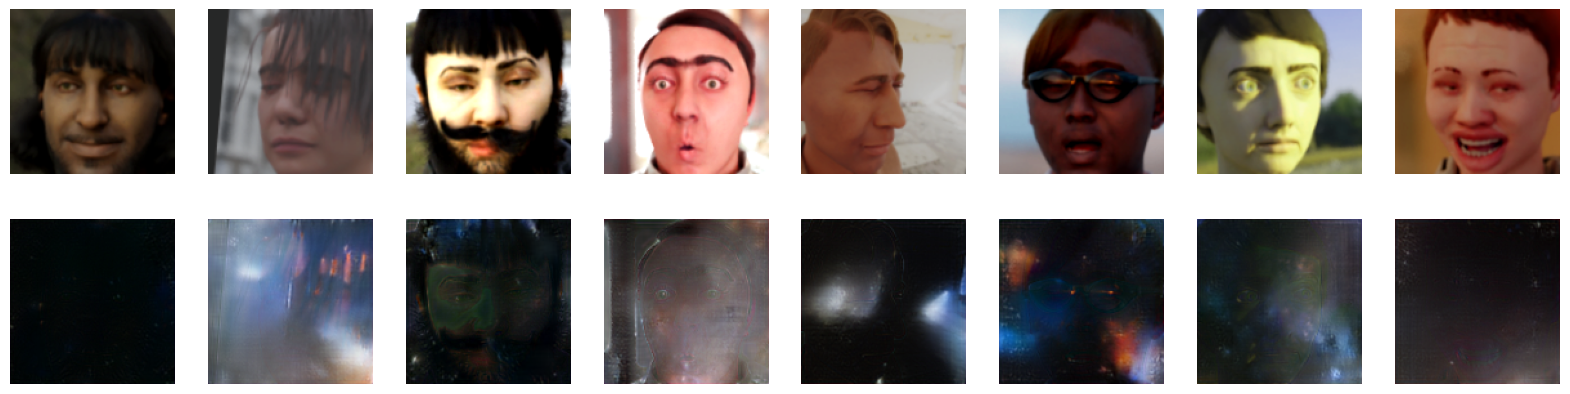

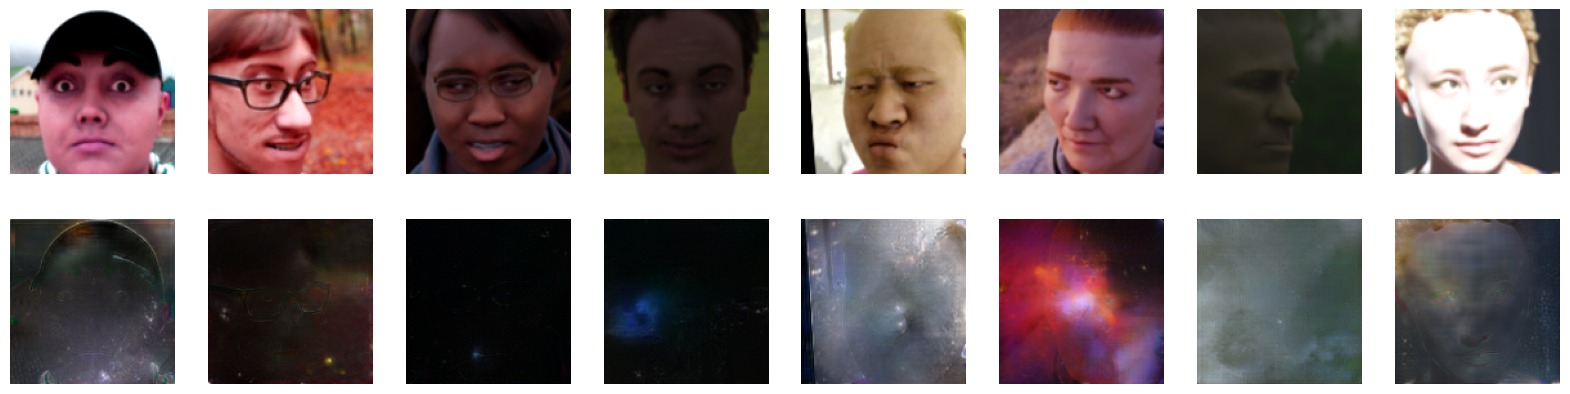

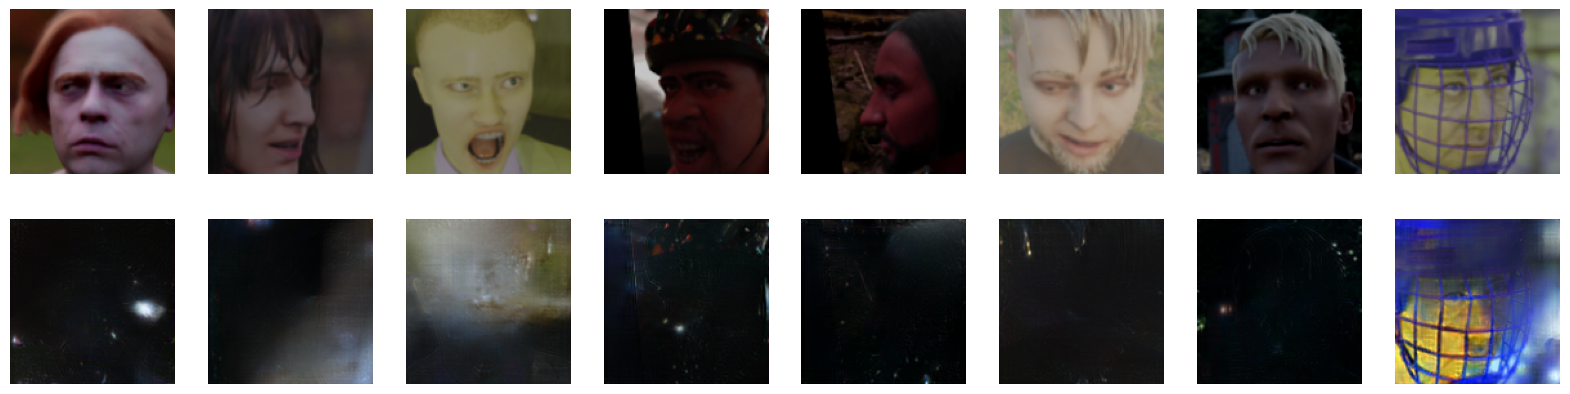

In [36]:
for j in range(10):
    x1 = next(iter(faces_loader))
    x1 = x1.to(device)


    x2 = model.sample(x0=x1, nb_steps=50).to(x1)


    x1 = x1*faces_ds.stds[None, :].to(x1) + faces_ds.means[None, :].to(x1)

    x2 = x2*hubble_ds.stds[None, :].to(x1) + hubble_ds.means[None, :].to(x1)

    x2 = x2.detach().cpu()

    n = x2.shape[0]
    f,ax = plt.subplots(2, n, figsize = (20,5))

    for j in range(x2.shape[0]):
        ax[1, j].imshow(x2[j].squeeze().permute(1, 2, 0))
        ax[1, j].axis('off')
        ax[0, j].imshow(x1[j].cpu().detach().squeeze().permute(1, 2, 0))
        ax[0, j].axis('off')
    plt.show()

In [9]:
import time
model.cpu()
x1= x1.cpu()
model.device = 'cpu'

st = time.time()

x2 = model.sample(x0=x1[:1], nb_steps=10).detach()

print(1/(time.time()-st))

0.22052014692496325


In [27]:
from PIL import Image

images = os.listdir("video_images")
images = sorted(images)
print(images)
images = [Image.open(os.path.join("video_images", img)).convert('RGB') for img in images]

['video-frame00001.png', 'video-frame00002.png', 'video-frame00003.png', 'video-frame00004.png', 'video-frame00005.png', 'video-frame00006.png', 'video-frame00007.png', 'video-frame00008.png', 'video-frame00009.png', 'video-frame00010.png', 'video-frame00011.png', 'video-frame00012.png', 'video-frame00013.png', 'video-frame00014.png', 'video-frame00015.png', 'video-frame00016.png', 'video-frame00017.png', 'video-frame00018.png', 'video-frame00019.png', 'video-frame00020.png', 'video-frame00021.png', 'video-frame00022.png', 'video-frame00023.png', 'video-frame00024.png', 'video-frame00025.png', 'video-frame00026.png', 'video-frame00027.png', 'video-frame00028.png', 'video-frame00029.png', 'video-frame00030.png', 'video-frame00031.png', 'video-frame00032.png', 'video-frame00033.png', 'video-frame00034.png', 'video-frame00035.png', 'video-frame00036.png', 'video-frame00037.png', 'video-frame00038.png', 'video-frame00039.png', 'video-frame00040.png', 'video-frame00041.png', 'video-frame000

In [28]:
import torchvision.transforms as T


import PIL.ImageOps

def to_negative(img):
    img = PIL.ImageOps.invert(img)
    return img

class Negative(object):
    """Convert image to negative.

    Args:
        

    Returns:
        PIL Image: Negative version of the input.
         
    """
    def __init__(self):
        pass
    
    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be converted to Negative.

        Returns:
            PIL Image: Negatived image.
        """
        return to_negative(img)
    
    

faces_transform = T.Compose([
        T.Resize((128, 128)),
       # Negative(),
        T.ToTensor(),
        ##T.Normalize(mean= [0.3898356258869171, 0.31504639983177185, 0.27228453755378723], 
        #            std=[0.22846238315105438, 0.21757572889328003, 0.2148447185754776])
    ])

images = [faces_transform(img) for img in images]
images = torch.stack(images)

In [29]:
#images = torch.cat(images)
means = images.mean(dim = (0,2,3))
stds = images.std(dim = (0,2,3))

#means = torch.tensor([-0.025829819962382317, -0.022021684795618057, -0.020416421815752983])
#stds = torch.tensor([0.9912844896316528, 0.9922241568565369, 0.9933313131332397])
images_norm = (images - means[None, :, None, None])/ stds[None, :, None, None]

In [ ]:
x2 = model.sample(x0=images_norm, nb_steps=10).detach().cpu()


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cpu!

In [32]:
x2 = x2*hubble_ds.stds[None, :].to(x2) + hubble_ds.means[None, :].to(x2)


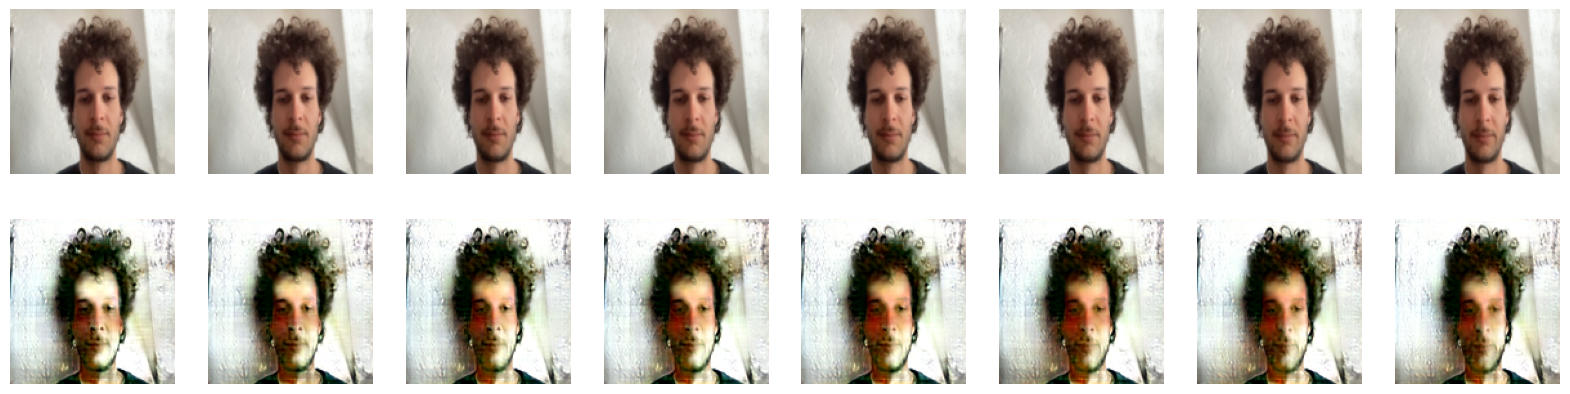

In [33]:
n = 8
f,ax = plt.subplots(2, n, figsize = (20,5))

for j in range(n):
    ax[1, j].imshow(x2[j].squeeze().permute(1, 2, 0))
    ax[1, j].axis('off')
    ax[0, j].imshow(images[j].cpu().detach().squeeze().permute(1, 2, 0))
    ax[0, j].axis('off')
        

In [195]:
import torchvision 
pil_out = torchvision.transforms.functional.to_pil_image(x2[0], mode=None)

In [196]:
import imageio
import os

image_folder = 'images'
video_name = 'video.mp4'

writer = imageio.get_writer(video_name, fps=20)


images_out = [xc.permute(1,2,0).numpy() for xc in x2]

#frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layer = images_out[0].shape

for image in images_out:
    writer.append_data(image)
    
writer.close()


In [138]:
video.save()

AttributeError: 'cv2.VideoWriter' object has no attribute 'save'